初始化spark环境
* 模块重载 https://github.com/jupyter/notebook/issues/1973

In [2]:
import findspark
findspark.init()

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession # SparkSession 是Spark 2.0版本的新入口
spark = SparkSession.builder.master('local').getOrCreate()

# 加载 utils.py 中的自定义方法
from utils import *

# 使能调用其他 ipynb 文件
# import ipynb_importer 

# 特征工程

* DataFrame操作 https://blog.csdn.net/sinat_26917383/article/details/80500349 
* DataFrame基础 https://zhuanlan.zhihu.com/p/34901683
* 处理稀疏特征 http://www.4o4notfound.org/index.php/archives/123/
* 用户自定义函数 https://stackoverflow.com/questions/29109916/updating-a-dataframe-column-in-spark

设置schema

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

In [4]:
schema = StructType([
StructField("duration",IntegerType(),False),
StructField("protocol_type",StringType(),False),
StructField("service",StringType(),False),
StructField("flag",StringType(),False),
StructField("src_bytes",IntegerType(),False),
StructField("dst_bytes",IntegerType(),False),
StructField("land",IntegerType(),False),
StructField("wrong_fragment",IntegerType(),False),
StructField("urgent",IntegerType(),False),
StructField("hot",IntegerType(),False),
StructField("num_failed_logins",IntegerType(),False),
StructField("logged_in",IntegerType(),False),
StructField("num_compromised",IntegerType(),False),
StructField("root_shell",IntegerType(),False),
StructField("su_attempted",IntegerType(),False),
StructField("num_root",IntegerType(),False),
StructField("num_file_creations",IntegerType(),False),
StructField("num_shells",IntegerType(),False),
StructField("num_access_files",IntegerType(),False),
StructField("num_outbound_cmds",IntegerType(),False),
StructField("is_host_login",IntegerType(),False),
StructField("is_guest_login",IntegerType(),False),
StructField("count",IntegerType(),False),
StructField("srv_count",IntegerType(),False),
StructField("serror_rate",FloatType(),False),
StructField("srv_serror_rate",FloatType(),False),
StructField("rerror_rate",FloatType(),False),
StructField("srv_rerror_rate",FloatType(),False),
StructField("same_srv_rate",FloatType(),False),
StructField("diff_srv_rate",FloatType(),False),
StructField("srv_diff_host_rate",FloatType(),False),
StructField("dst_host_count",IntegerType(),False),
StructField("dst_host_srv_count",IntegerType(),False),
StructField("dst_host_same_srv_rate",FloatType(),False),
StructField("dst_host_diff_srv_rate",FloatType(),False),
StructField("dst_host_same_src_port_rate",FloatType(),False),
StructField("dst_host_srv_diff_host_rate",FloatType(),False),
StructField("dst_host_serror_rate",FloatType(),False),
StructField("dst_host_srv_serror_rate",FloatType(),False),
StructField("dst_host_rerror_rate",FloatType(),False),
StructField("dst_host_srv_rerror_rate",FloatType(),False),
StructField("label",StringType(),False)
])

从本地读取数据

In [5]:
# 从csv中读取
dataset = spark.read.csv('Data/kddcup.data_10_percent.gz', header=None,schema=schema)
dataset.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

合并稀疏特征

In [6]:
from utils import mapper_mergeSparseFeatureInService
import pyspark.sql.functions as F

# 用户自定义函数
udf_mergeSparseFeatureInService = F.UserDefinedFunction(mapper_mergeSparseFeatureInService,StringType())

In [12]:
dataset = dataset.select(
    *[udf_mergeSparseFeatureInService(column).alias('service') if column == 'service' else column for column in dataset.columns]
)
dataset.select('service').show(2)

+-------+
|service|
+-------+
|   http|
|   http|
+-------+
only showing top 2 rows



划分攻击类型

In [8]:
from utils import mapper_attack2majorindex

udf_mapper_attack2majorindex = F.UserDefinedFunction(mapper_attack2majorindex,IntegerType())

In [11]:
dataset = dataset.select(
    *[udf_mapper_attack2majorindex(column).alias('label') if column == 'label' else column for column in dataset.columns]
)
dataset.select('label').show(2)

+-----+
|label|
+-----+
|    0|
|    0|
+-----+
only showing top 2 rows



分类编码 Pipeline 

In [27]:
from pyspark.ml.feature import StringIndexer

fearture_string = ['protocol_type', 'service', 'flag']
pipeline_stringindex = Pipeline(stages=[
    StringIndexer(inputCol=c, outputCol='{}_index'.format(c),handleInvalid='keep')
    for c in fearture_string
])

pipeline_stringindex_fitted = pipeline_stringindex.fit(dataset=dataset)

In [13]:
dataset_indexed = pipeline_stringindex_fitted.transform(dataset=dataset)

In [14]:
dataset_indexed.select('protocol_type','protocol_type_index','service','service_index','flag','flag_index','label').show(5)

+-------------+-------------------+-------+-------------+----+----------+-----+
|protocol_type|protocol_type_index|service|service_index|flag|flag_index|label|
+-------------+-------------------+-------+-------------+----+----------+-----+
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
+-------------+-------------------+-------+-------------+----+----------+-----+
only showing top 5 rows



In [63]:
# 存储 pipeline
pipeline_stringindex_fitted.save('SparkRF/pipeline_stringindex_fitted')

In [9]:
# 加载 pipeline
from pyspark.ml import PipelineModel
pipeline_stringindex_fitted = PipelineModel.load('SparkRF/pipeline_stringindex_fitted')

# 随机森林

* maxBin取值 https://stackoverflow.com/questions/38767786/spark-mllib-2-0-categorical-features-in-pipeline

In [15]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from time import time

构造训练集 [features][label]

In [16]:
def featuresToVec(dataset_indexed):
    # 构造特征向量
    features=[dataset_indexed.columns[0]]+dataset_indexed.columns[4:]
    features.remove('label')
    feature_vec = VectorAssembler(inputCols=features,outputCol='feature_vec').transform(dataset_indexed)
    # 组合数据集： 特征向量，标签
    return feature_vec.select('feature_vec','label')

In [17]:
dataset_indexed = featuresToVec(dataset_indexed)

In [18]:
# 划分训练集，测试集
train_set,test_set = dataset_indexed.randomSplit([0.8,0.2])

In [9]:
rf = RandomForestClassifier(
    featuresCol='feature_vec', # 特征
    labelCol='label', #标签
    impurity='gini', # 考虑到样本分布和计算效率
    maxDepth=8, # 最大深度
    maxBins=72, # 根据样本训练集确定
    numTrees=200, # 树个数
    subsamplingRate = 1.0, # 默认值，用于训练每棵树的数据占总训练集比例，可用于加速
    seed=5, 
)

In [36]:
# 训练模型
t0 = time()
rf_model = rf.fit(train_set)
tt = time() -t0
print("Trains in {} seconds".format(round(tt,3)))

Trains in 451.235 seconds


In [50]:
# 保存训练好的机器学习模型
rf_model.save('SparkRF/rf_SparkRF')

In [19]:
# 加载本地机器学习模型
from pyspark.ml.classification import RandomForestClassificationModel
rf_model=RandomForestClassificationModel.load('SparkRF/rf_SparkRF')

In [20]:
# 预测
t0 = time()
test_result = rf_model.transform(test_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.129 seconds


# 评价

#### 交叉验证打分

In [57]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [74]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score={}
# for metric in ['accuracy','f1','weightedPrecision','weightedRecall']:
for metric in ['accuracy','f1']:
    t0 = time()
    score[metric] = evaluator.evaluate(dataset=test_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score[metric], round(tt,3)))
    

accuracy                       0.999515 	 69.876000
f1                             0.999506 	 99.630000


### 验证集打分

数据导入与处理

In [21]:
corrected = spark.read.csv('Data/corrected.gz', header=None,schema=schema)

# 合并稀疏特征
corrected = corrected.select(
    *[udf_mergeSparseFeatureInService(column).alias('service') if column == 'service' else column for column in corrected.columns]
)
# 攻击类型分类
corrected = corrected.select(
    *[udf_mapper_attack2majorindex(column).alias('label') if column == 'label' else column for column in corrected.columns]
)
# 分类编码
corrected_indexed = pipeline_stringindex_fitted.transform(corrected)

# 划分 features vector 和 label
corrected_set = featuresToVec(corrected_indexed)

预测

In [22]:
t0 = time()
corrected_result = rf_model.transform(corrected_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.029 seconds


评价

In [60]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score_corrected={}
# for metric in ['accuracy','weightedPrecision','weightedRecall','f1']:
for metric in ['accuracy','f1']:
    t0 = time()
    score_corrected[metric] = evaluator.evaluate(dataset=corrected_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score_corrected[metric], round(tt,3)))

accuracy                       0.923110 	 134.500000 seconds
f1                             0.903440 	 252.941000 seconds


# 混淆矩阵

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [24]:
# convert DF column to list
def getListFromDF(df,colname):
    tmp = df.select(colname).toPandas()
    return tmp.iloc[:,0].values

In [25]:
# 直接根据测试结果DF 绘制混淆矩阵,并输出评分
def drawFromDF(dataset):
    true = getListFromDF(dataset,'label')
    pred = getListFromDF(dataset,'prediction')
    cm,plt = drawConfusionMatrix(true,pred,[0,1,2,3,4])
    plt.show()
    preAndRec(cm=cm,labels=[0,1,2,3,4])
    return cm,true,pred

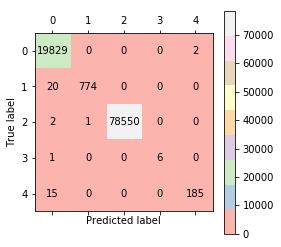

------------------------------
Precision:
0 : 	 0.998087
1 : 	 0.998710
2 : 	 1.000000
3 : 	 1.000000
4 : 	 0.989305

Recall:
0 : 	 0.999899
1 : 	 0.974811
2 : 	 0.999962
3 : 	 0.857143
4 : 	 0.925000
------------------------------


In [26]:
test_cm,test_true,test_pred = drawFromDF(dataset=test_result)

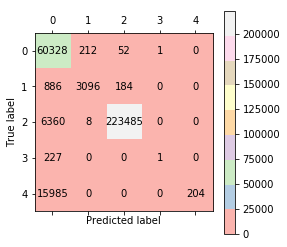

------------------------------
Precision:
0 : 	 0.720025
1 : 	 0.933655
2 : 	 0.998945
3 : 	 0.500000
4 : 	 1.000000

Recall:
0 : 	 0.995627
1 : 	 0.743159
2 : 	 0.972295
3 : 	 0.004386
4 : 	 0.012601
------------------------------


In [27]:
corrected_cm,corrected_true,corrected_pred = drawFromDF(dataset=corrected_result)

# 二次训练

提取错误样本集

In [32]:
error_set = test_result.where('label != prediction') # error_set 已有 prediction 等列,共41个样本

error_corrected_set = corrected_result.where('label != prediction') # 共23915个样本

train2_set = train_set.unionAll(error_set.drop('rawPrediction','prediction','probability')) 

train2_set = train2_set.unionAll(error_corrected_set.drop('rawPrediction','prediction','probability'))  # 共418592个样本

训练

In [52]:
rf2 = RandomForestClassifier(
    featuresCol='feature_vec', # 特征
    labelCol='label', #标签
    impurity='gini', # 考虑到样本分布和计算效率
    maxBins=72, # 根据样本训练集确定
    numTrees=200, # 树个数
    subsamplingRate = 1.0, # 默认值，用于训练每棵树的数据占总训练集比例，可用于加速
)

In [53]:
# 训练模型
t0 = time()
rf2_model = rf2.fit(train2_set)
tt = time() -t0
print("Trains in {} seconds".format(round(tt,3)))

Trains in 614.033 seconds


In [54]:
# 保存训练好的机器学习模型
rf2_model.save('SparkRF/rf2_model')

In [ ]:
# 加载本地机器学习模型
from pyspark.ml.classification import RandomForestClassificationModel
rf_model=RandomForestClassificationModel.load('SparkRF/rf2_model')

预测

In [55]:
# 预测
t0 = time()
test2_corrected_result = rf2_model.transform(corrected_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.058 seconds


评价

In [58]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score_test2={}
# for metric in ['accuracy','weightedPrecision','weightedRecall','f1']:
for metric in ['accuracy','f1']:
    t0 = time()
    score_test2[metric] = evaluator.evaluate(dataset=test2_corrected_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score_test2[metric], round(tt,3)))

accuracy                       0.954416 	 100.858000 seconds
f1                             0.957008 	 187.015000 seconds


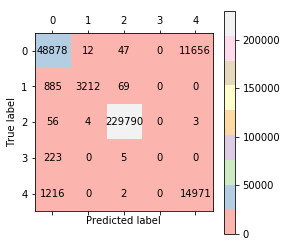

------------------------------
Precision:
0 : 	 0.953568
1 : 	 0.995043
2 : 	 0.999465
3 : 	 nan
4 : 	 0.562186

Recall:
0 : 	 0.806661
1 : 	 0.771003
2 : 	 0.999726
3 : 	 0.000000
4 : 	 0.924764
------------------------------


C:\Users\asus\Desktop\lab\utils.py:174: RuntimeWarning: invalid value encountered in longlong_scalars
  result[x]= tp/s if s is not 0 else 0


In [59]:
test2_corrected_cm,test2_corrected_true,test2_corrected_pred = drawFromDF(dataset=test2_corrected_result)